<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Установка-необходимых-версий,-загрузки-библиотек-и-объявление-констант" data-toc-modified-id="Установка-необходимых-версий,-загрузки-библиотек-и-объявление-констант-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Установка необходимых версий, загрузки библиотек и объявление констант</a></span></li><li><span><a href="#Загрузка-данных-из-файла" data-toc-modified-id="Загрузка-данных-из-файла-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Загрузка данных из файла</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Построим-график-заказов-и-посмотрим-на-скользящее-среднее" data-toc-modified-id="Построим-график-заказов-и-посмотрим-на-скользящее-среднее-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Построим график заказов и посмотрим на скользящее среднее</a></span></li><li><span><a href="#Посмотрим-на-тренды-и-сезонность" data-toc-modified-id="Посмотрим-на-тренды-и-сезонность-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Посмотрим на тренды и сезонность</a></span></li><li><span><a href="#Создадим-новые-признаки" data-toc-modified-id="Создадим-новые-признаки-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Создадим новые признаки</a></span></li><li><span><a href="#Разделим-выборку-на-тренировочную-и-тестовую-выборку" data-toc-modified-id="Разделим-выборку-на-тренировочную-и-тестовую-выборку-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Разделим выборку на тренировочную и тестовую выборку</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

**Цель исследования:** Построить модель для прогнозирования заказов такси на следующий час

**Описание проекта:** Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**Ход работы:**

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


**Описание данных:** Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders`.

## Подготовка

### Установка необходимых версий, загрузки библиотек и объявление констант

In [1]:
!pip install -U scikit-learn

In [2]:
!pip install phik

In [3]:
!pip install -U shap matplotlib

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import shap
from sklearn.preprocessing import OneHotEncoder
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
RANDOM_STATE = 42

### Загрузка данных из файла

Загрузим данные из файла, приведем дату к типу данных datetime, установим индекс таблицы, равным столбцу datetime

In [3]:
data = pd.read_csv('taxi.csv', parse_dates=[0], index_col=[0])

In [4]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Отсортируем столбец datetime по возрастанию

In [6]:
data.sort_index(inplace=True)

Поверим, есть ли в таблице явные дубликаты

In [7]:
data.duplicated().sum()

26415

Выделим временной промежуток, равный одному часу

In [8]:
data = data.resample('1h').sum()

In [9]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**Вывод:** Загрузила данные, поменяла тип даты на datetime, отсротировала значения даты по возрастанию, выполнила ресемплирование по одному часу.

## Анализ

### Построим график заказов и посмотрим на скользящее среднее

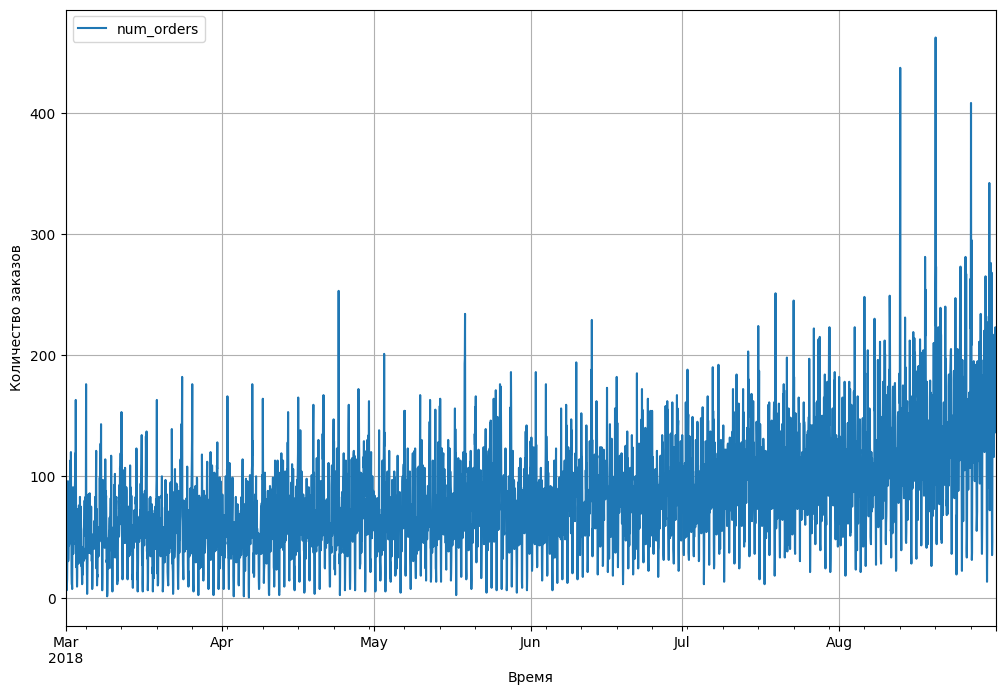

In [10]:
data.plot(figsize=(12, 8))
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.grid()
plt.show()

Данные предоставлены за 6 месяцев 2018 года, с марта по сентябрю

### Посмотрим на тренды и сезонность

In [11]:
decomposed = seasonal_decompose(data) 

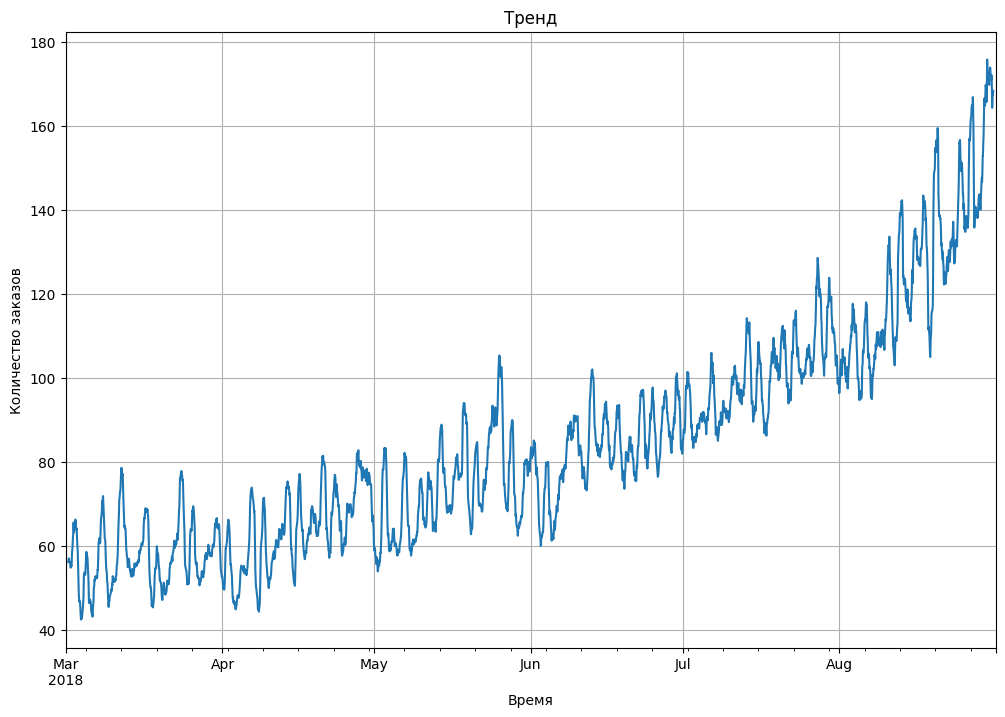

In [12]:
decomposed.trend.plot(figsize=(12, 8))
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.title('Тренд')
plt.grid()
plt.show()

С марта по сентябрь количество заказов стабильно растет, скорее всего это связано с сезоном отпусков

Посмотрим сезонности ряда, чтобы график был информативен, выберем интервал, чтобы был виден каждый час

In [13]:
data_seasonal = data['2018-03-01':'2018-03-02'].resample('1H').sum()
decomposed_seasonal = seasonal_decompose(data_seasonal) 

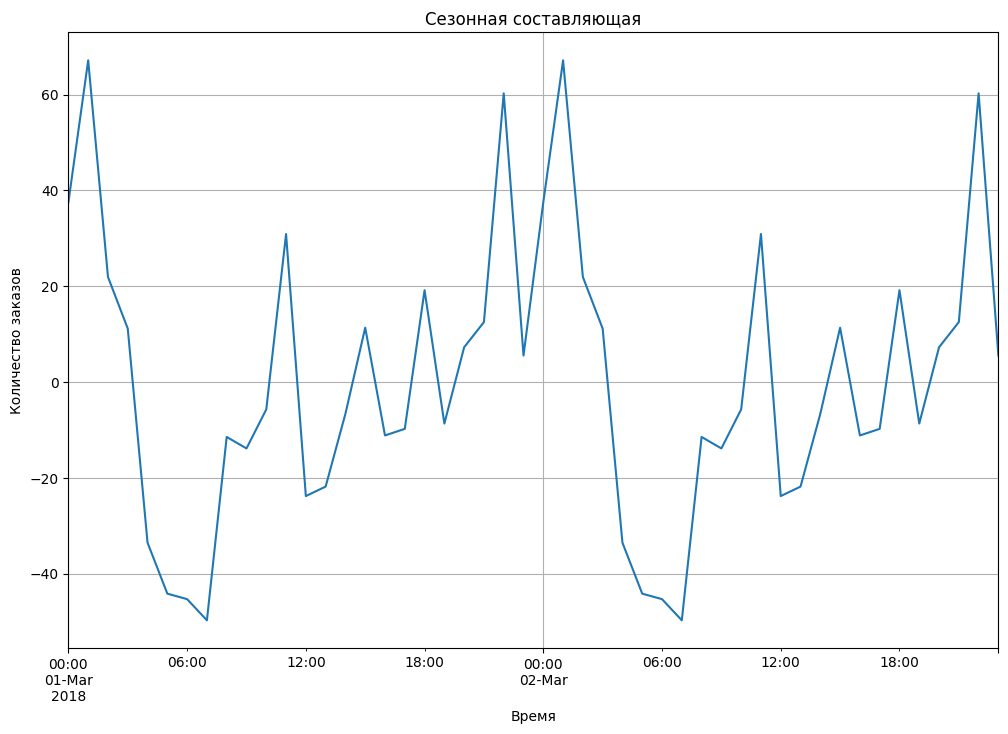

In [14]:
decomposed_seasonal.seasonal.plot(figsize=(12, 8))
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.title('Сезонная составляющая')
plt.grid(True)
plt.show()

Сезонность связана с временем суток. Ночью количество заказов меньше.</font>

Ресемплируем ряд по дню и выведем интервал сезонной компоненты около месяца, так мы сможем увидеть сезонность внутри недели.

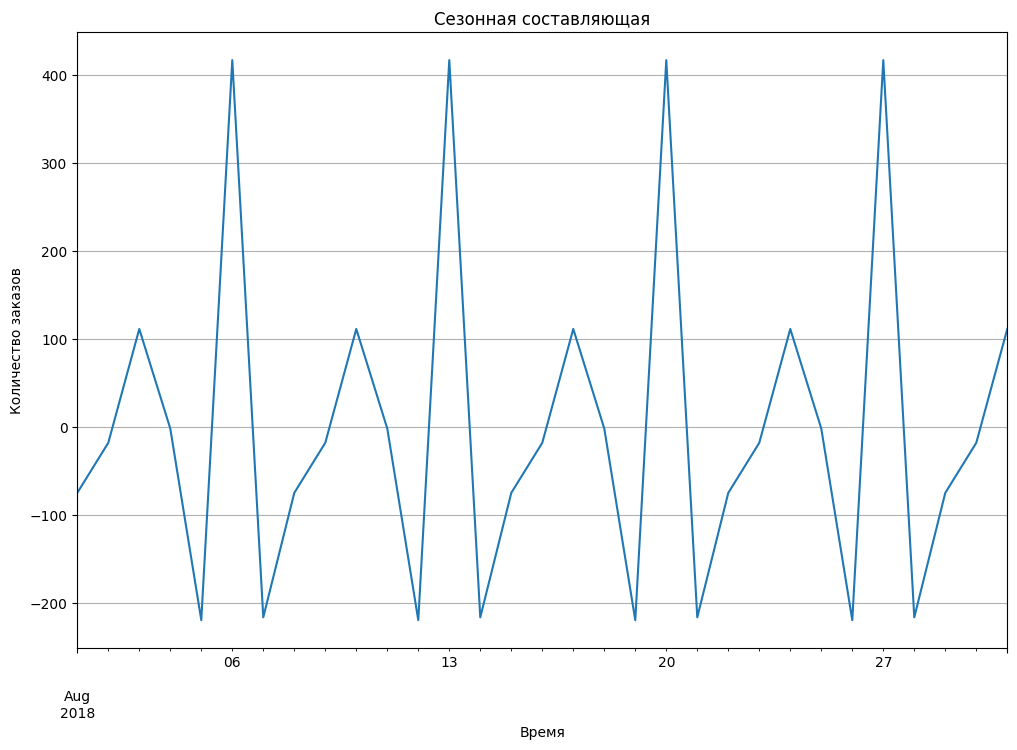

In [15]:
data_seasonal_week = data['2018-08-01':'2018-08-31'].resample('1D').sum()
decomposed_seasonal_week = seasonal_decompose(data_seasonal_week)
decomposed_seasonal_week.seasonal.plot(figsize=(12, 8))
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.title('Сезонная составляющая')
plt.grid()
plt.show()

Пики активности приходятся на понедельники

Проверим стационарность с помощью теста Дики-Фуллера

H0: Процесс нестационарный

H1: Процесс стационарный

In [16]:
adf_test = adfuller(data['num_orders'])
adf_test[1]

0.028940051402614502

p-value меньше 0,05 мы можем отвергнуть гипотезу, что процесс нестационарый

Значение с индексом 1 меньше P-Value, значит ряд стационарный.

### Создадим новые признаки

* **Календарные признаки:** Добавим в таблицу час и день недели
* **Отстающие значения**
* **Скользящее среднее** 

In [17]:
def make_features(df, max_lag, rolling_mean_size):
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
        data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
        
    data['diff'] = data['num_orders'].shift().diff(periods = 2)

Так же позже добавила в признаки разность временного ряда, так как изначально модель сильно недоучилась.

In [18]:
make_features(data, 50, 4)

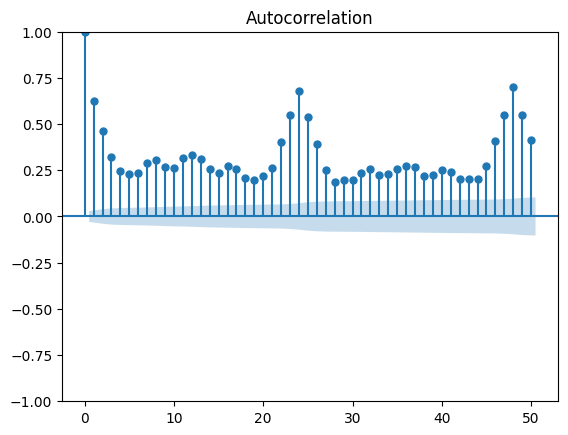

<Figure size 4000x2000 with 0 Axes>

In [19]:
plot_acf(data['num_orders'], lags=50, ax=plt.gca())
plt.figure(figsize=(40,20))
plt.show()

 Самые значимы лаги - 24й, 1й, 2й, 22й, 23й. Остальные столбцы я удалю.

In [20]:
data = data[['num_orders', 'hour', 'day_of_week', 'lag_1', 'lag_2', 'lag_22', 'lag_23', 'lag_24', 'lag_25']]

In [21]:
data.head()

,num_orders,hour,day_of_week,lag_1,lag_2,lag_22,lag_23,lag_24,lag_25
datetime,,,,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3,66.0,71.0,NaN,NaN,NaN,NaN


In [22]:
data = data.dropna(axis=0)

In [23]:
data.head()

,num_orders,hour,day_of_week,lag_1,lag_2,lag_22,lag_23,lag_24,lag_25
datetime,,,,,,,,,
2018-03-02 01:00:00,120,1,4,90.0,58.0,66.0,71.0,85.0,124.0
2018-03-02 02:00:00,75,2,4,120.0,90.0,43.0,66.0,71.0,85.0
2018-03-02 03:00:00,64,3,4,75.0,120.0,6.0,43.0,66.0,71.0
2018-03-02 04:00:00,20,4,4,64.0,75.0,12.0,6.0,43.0,66.0
2018-03-02 05:00:00,11,5,4,20.0,64.0,15.0,12.0,6.0,43.0


### Разделим выборку на тренировочную и тестовую выборку

In [24]:
X = data.drop(['num_orders'], axis=1)
y = data['num_orders']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1, random_state=RANDOM_STATE)

Подготовим пайплайны для подготовки даннх

In [26]:
num_columns = ['lag_1', 'lag_2', 'lag_22', 'lag_23', 'lag_24', 'lag_25']
ohe_columns = ['hour', 'day_of_week']

Кодируем признаки [dayofweek, hour] с помощью OHE-кодирования

In [27]:
num_pipe = Pipeline(
    [
        ('scaler', StandardScaler())
    ]
)

In [28]:
ohe_pipe = Pipeline(
    [
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

In [29]:
data_preprocessor = ColumnTransformer(
    [
        ('num', num_pipe, num_columns),
        ('ohe', ohe_pipe, ohe_columns)
    ],
    remainder='passthrough',
    force_int_remainder_cols=False
)

In [30]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor())
    ]
)

Подготовим пайплайн для поиска гиперпараметров

In [31]:
param_grid = [
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [SVC()],
        'models__C': range(1, 5),
        'models__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__min_samples_split': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [KNeighborsRegressor()],
        'models__n_neighbors': range(2, 30),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [LGBMRegressor()],
        'models__num_leaves': range(1, 31),
        'models__max_depth': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [32]:
tscv = TimeSeriesSplit(n_splits=3)

In [33]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=20
)

## Обучение

Найдем лучшую модель и оценку

In [34]:
randomized_search.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1194
[LightGBM] [Info] Number of data points in the train set: 3951, number of used features: 35
[LightGBM] [Info] Start training from score 78.448494
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(force_int_remainder_cols=False,
                                                                remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['lag_1',
                                                                                'lag_2',
                                                                                'lag_22',
                                                                                'lag_23',
                                                                                'lag_24',
                                                                                'lag_25']),
                                                                              ('ohe',
                                                                               Pipeline(steps=...
                                        {'models': [KNeighborsRegressor()],
                                         'models__n_neighbors': range(2, 30),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LGBMRegressor()],
                                         'models__max_depth': range(1, 10),
                                         'models__num_leaves': range(1, 31),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [35]:
randomized_search.best_score_

-27.77665399925637

In [36]:
randomized_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('num', 'passthrough',
                                                  ['lag_1', 'lag_2', 'lag_22',
                                                   'lag_23', 'lag_24',
                                                   'lag_25']),
                                                 ('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['hour', 'day_of_week'])])),
                ('models', LGBMRegressor(max_depth=2, num_leaves=13))])

Лучшей оказалась модель градиентного бустинга LGBMRegressor c гиперпараметрами max_depth=2, num_leaves=13. RMSE на тренировочной выборка равна 27,7, по заданию, оценка не должна превышать 48

Найдем предсказания модели

In [37]:
pred = randomized_search.predict(X_test)

C:\Users\peredkova\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


## Тестирование

Проверим данные на тестовой выборке

In [38]:
rmse = mean_squared_error(y_test, pred)**0.5
rmse

45.1695007091203

RMSE=45,1, оценка на тестовой выборке значительно выше, чем на тренировочной, тем не менее она соответствует условиям задачи.

## Вывод

Я изучила исторические данные компании "Четенькое такси" о заказах такси в аэропортах. Данные в датасете были представлены с начала марта по конец августа. 
* Проведя анализ данных, я выяснила, что с наступлением лета количество заказов в такси стабильно растет, скорее всего это связано с сезоном отпусков. Закономерности по количеству заказов в течение дня я не обнаружила. Думаю это связано с тем, что самолеты прилетают в любое время дня.
* Для обучения модели я добавила в датасет новые признаки: календарные признаки (час, день недели и месяц), отстающие значения, скользящее среднее. После выбора, обучения и тестирования модели выянилось, что модель недообучилась, поэтому я решила добавить еще один признак - разность временного ряда.
* Для выполнения задачи я обучила 5 разных моделей: LinearRegression, SVC, DecisionTreeRegressor, KNeighborsRegressor и LGBMRegressor и подобрала для них гиперпараметры. Лучшей оказалась модель LGBMRegressor c гиперпараметрами max_depth=2, num_leaves=13. 
RMSE на тренировочной выборка равна 27,7 
* Проведя тестирование модели на тестовых данных я получила RMSE = 45,1